# Loading the pre-trained model

In [2]:
from typing import Callable
from torch.utils.data import DataLoader
from careamics.lightning import VAEModule

from configs.factory import *
from datasets import create_train_val_datasets

def setup_denoiSplit(
    data_path: str,
    param_fn: Callable,
    data_configs_fn: Callable,
    load_data_fn: Callable,
) -> None:
    params = param_fn()
    
    # get datasets and dataloaders
    train_data_config, val_data_config = data_configs_fn()
    train_dset, val_dset, _, data_stats = create_train_val_datasets(
        datapath=data_path,
        train_config=train_data_config,
        val_config=val_data_config,
        test_config=val_data_config, # TODO: check this
        load_data_func=load_data_fn,
    )
    
    # get configs
    params["data_stats"] = data_stats
    loss_config = get_loss_config(**params)
    model_config = get_model_config(**params)
    gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(**params)
    lr_scheduler_config = get_lr_scheduler_config(**params)
    optimizer_config = get_optimizer_config(**params)
    # TODO: all the previous configs can also be istantiated from a single function...
    algo_config = get_algorithm_config(
        algorithm=params["algorithm"],
        loss_config=loss_config,
        model_config=model_config,
        gaussian_lik_config=gaussian_lik_config,
        nm_config=noise_model_config,
        nm_lik_config=nm_lik_config,
        lr_scheduler_config=lr_scheduler_config,
        optimizer_config=optimizer_config
    )   
    lightning_model = VAEModule(algorithm_config=algo_config)
    return {'model': lightning_model, 'train_dset': train_dset, 'val_dset': val_dset, 'params': params}

In [3]:
from configs.parameters.ht_iba1_ki64_2023 import get_denoisplit_parameters 

from configs.data.puncta_removal import get_train_data_configs
from datasets.multicrop_dset_train_val_data import get_train_val_data

data_path = '/group/jug/ashesh/data/Elisa/patchdataset/'
def modified_param_fn():
        params = get_denoisplit_parameters()
        params['multiscale_count'] = 1
        return params
    
setup_dict = setup_denoiSplit(
    data_path,
    modified_param_fn,
    get_train_data_configs,
    get_train_val_data,
)

Train: 38 Val: 5 Test: 5
Train: 61 Val: 17 Test: 4
MultiCropDset N:8596 Rot:False Ch:2 MaxVal:None Bg:[0, 0]
Train: 38 Val: 5 Test: 5
Train: 61 Val: 17 Test: 4
MultiCropDset N:1130 Rot:False Ch:2 MaxVal:None Bg:[0, 0]
Train: 38 Val: 5 Test: 5
Train: 61 Val: 17 Test: 4
MultiCropDset N:1130 Rot:False Ch:2 MaxVal:None Bg:[0, 0]
[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[MultiChannelNoiseModel] Nmodels count:2
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


/home/ashesh.ashesh/code/careamics/src/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


In [4]:
train_dset = setup_dict['train_dset']
val_dset = setup_dict['val_dset']
len(train_dset), len(val_dset)

(8596, 1130)

In [5]:
import torch
import numpy as np
import random

def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

0.24321058 1.0982704


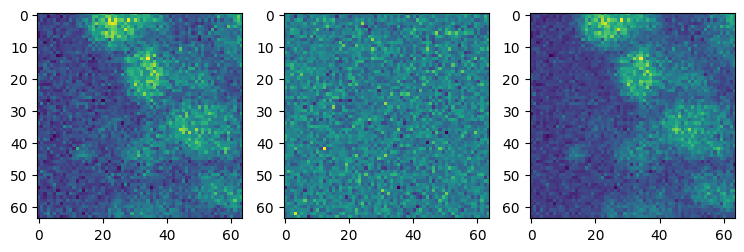

In [6]:
import matplotlib.pyplot as plt
_,ax = plt.subplots(figsize=(9,3),ncols=3)
fix_seeds()
inp, tar = val_dset[0]
ax[0].imshow(inp[0])
ax[1].imshow(tar[0])
ax[2].imshow(tar[1])
print(inp.mean(), inp.std())


In [7]:
import torch
# ckpt_dir = '//group/jug/ashesh/training/naturemethodtesting/2411/denoisplit_HTIba1Ki67/6/best-epoch=38.ckpt'
ckpt_dir = '/group/jug/ashesh/training/naturemethodtesting/2411/denoisplit_PunctaRemoval/1/last.ckpt'
model = setup_dict['model']
# get the parameters from the checkpoint
model.load_state_dict(torch.load(ckpt_dir)['state_dict'], strict=True)
# to cuda
model = model.cuda()

# Load the data to evaluate

In [8]:
from skimage.io import imread
import numpy as np

test_fpath = '/group/jug/ashesh/data/Elisa/test/DIF_17_Day_25_Untreated_1_4_0001.nd2.tif'
data = imread(test_fpath, plugin="tifffile")
# pick the second channel
data = data[..., 1]

# pick one random frame
test_z_idx = 8
test_data= data[test_z_idx:test_z_idx+1].copy()
test_data = test_data.astype(np.float32)
# test_data -= config.data.background_values[0]

### Some boilerplate code for normalization

In [9]:
def l2(x):
    return np.sqrt(np.mean(np.array(x)**2))

def sample_crop(sz):
    t = np.random.randint(0, len(test_data))
    x = np.random.randint(0, test_data.shape[1] - sz)
    y = np.random.randint(0, test_data.shape[2] - sz)
    crop = test_data[t, x:x+sz, y:y+sz]
    return crop

def compute_mean_std():
    mean_inp = []
    std_inp = []
    image_size = setup_dict['params']['img_size']
    assert image_size[0] == image_size[1]
    image_size = image_size[0]
    for _ in range(30000):
        crop = sample_crop(image_size)
        mean_inp.append(np.mean(crop))
        std_inp.append(np.std(crop))

    output_mean = {}
    output_std = {}
    output_mean['input'] = np.array([np.mean(mean_inp)]).reshape(-1,1,1,1)
    output_std['input'] = np.array([l2(std_inp)]).reshape(-1,1,1,1)
    
    output_mean['target'] = np.tile(output_mean['input'],(1,2,1,1))
    output_std['target'] = np.tile(output_std['input'],(1,2,1,1))
    return output_mean, output_std

In [10]:
mean_dict, std_dict = compute_mean_std()
def normalizer(x):
    return (x - mean_dict['input'].squeeze()) / std_dict['input'].squeeze()

In [11]:
from datasets.evaluation_dset import EvaluationDset
image_size = setup_dict['params']['img_size'][0]
grid_size  = image_size//2
test_dset = EvaluationDset(test_data,normalizer_fn=normalizer, image_size=image_size, grid_size=grid_size)

In [12]:
from tqdm import tqdm
def get_dset_predictions(model, dset, batch_size, mmse_count=1, num_workers=4):
    dloader = DataLoader(dset, pin_memory=False, num_workers=num_workers, shuffle=False, batch_size=batch_size)
    predictions = []
    predictions_std = []
    with torch.no_grad():
        for inp in tqdm(dloader):
            inp = inp.cuda()
            recon_img_list = []
            for mmse_idx in range(mmse_count):
                imgs, _ = model(inp)
                # ignore the logvar predictions.
                imgs, _ = torch.split(imgs, 2, dim=1)
                recon_img_list.append(imgs.cpu()[None])

            samples = torch.cat(recon_img_list, dim=0)
            mmse_imgs = torch.mean(samples, dim=0)
            mmse_std = torch.std(samples, dim=0)
            predictions.append(mmse_imgs.cpu().numpy())
            predictions_std.append(mmse_std.cpu().numpy())
    return np.concatenate(predictions, axis=0), np.concatenate(predictions_std, axis=0)


In [13]:
pred_tiles, std_tiles = get_dset_predictions(model, test_dset, 64, mmse_count=1)

  0%|          | 0/142 [00:00<?, ?it/s]

/tmp/ipykernel_12601/1877883363.py:18: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/ReduceOps.cpp:1807.)
  mmse_std = torch.std(samples, dim=0)
100%|██████████| 142/142 [00:15<00:00,  9.37it/s]


In [14]:
from careamics.lvae_training.eval_utils import stitch_predictions_new
pred = stitch_predictions_new(pred_tiles,test_dset)


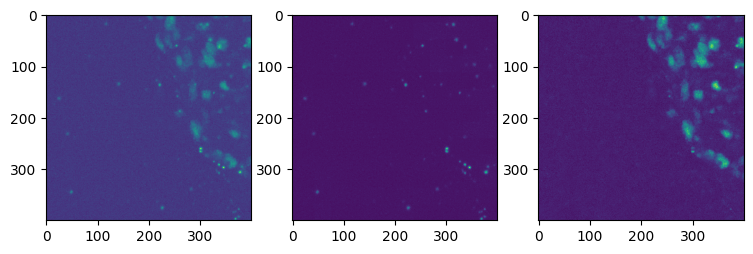

In [34]:
import matplotlib.pyplot as plt

_,ax = plt.subplots(figsize=(9,3),ncols=3)
sz = 400
h = np.random.randint(0, test_data.shape[1] - sz)
w = np.random.randint(0, test_data.shape[2] - sz)
ax[0].imshow(test_data[0,h:h+sz,w:w+sz])
ax[1].imshow(pred[0,h:h+sz,w:w+sz,0])
ax[2].imshow(pred[0,h:h+sz,w:w+sz,1])